<a href="https://colab.research.google.com/github/Akeshala/Radar-and-Navigation/blob/main/Assignment%201/Radar_Assignmnet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Radar and Navigation - Assignmnet 1
M.M.C.A. Marasinghe - 170376V

# Section 1

### Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2 as cv
import io

### Import dataset

In [ ]:
#@title Select test case using dropdown menu { display-mode: "form" }
file_name = "raw_data1.csv" #@param ["raw_data1.csv", "raw_data2.csv", "raw_data3.csv"]

In [ ]:
path = "https://raw.githubusercontent.com/Akeshala/Radar-and-Navigation/main/Assignment%201/" + file_name
df = pd.read_csv(path, sep=';', header=None, squeeze=True)


# *****************************
path_test = ""  # Add new link here to test, Uncomment the line below
# df = pd.read_csv(path_test, sep=';', header=None, squeeze=True) 
# *****************************

In [ ]:
data = df.to_numpy()

### Set parameters



*   Number of samples = 18000
*   Sampling rate = 1080 kHz
*   Range slots = 30
*   Window size for threshold detection = 21
*   Guard band size = 4
*   Pulse repetition frequency = 1800 Hz
*   Horizontal Beam Width = 2˚
*   Radar Rotation Speed = 12 RPM
*   $\sigma_n = 1$

*   $k = 1.3$








In [ ]:
# Radar parameters

Fs_orig = 1080*1000 # original sampling freq 1080kHz
N = 30 # no of bins
fr = 1800 # pulse repitition freq
revol_speed = 12 # revolution speed of radar
theta_initial = 0
theta_h = 2

# thresholding
sigma_n = 1
k = 1.3 # Not given in the assignmnet
guard_band = 4
one_side = 10 # (window_size - 1)/2, window_size=21

# Min echoes to be detected as a object
min_bins = N*0.5

speed_of_light = 300000000

As $ n_{samples} = 18000$ and $fs = 1080000 $, $T_{sampled}$ can be calculated from this equation. 
  
  >$T_{sampled} = \frac{n_{samples}}{fs} = \frac{1}{60} s$

  >$\theta_{revolved} = \frac{revol\ speed \times T_{sampled} \times 360^{\circ}}{60} = 1.2^{\circ}$

Dataset containes pulses for 1.2 degrees. Horizontal bandwidth is less than 2 degrees. Therefore, only a single data matrix is needed. 

In [ ]:
t_sampled = len(data)/Fs_orig
theta_revol = revol_speed*t_sampled*360/60
print("Dataset has pulses for " + str(theta_revol) + " degrees")

Dataset has pulses for 1.2 degrees


### Downsampling of raw data

As $f_r = 18kHz$ and $N = 30$, required sampling frequency is:

>$F_s = Nf_r$

>$F_s = 54kHz$

Since raw data has been sampled in $1080kHz$, this data need to be down-sampled to $54kHz\:\:$. Therefore, downsampling factor $M$ in discrete domain is:

>$M = \frac{1080}{54} = 20$

In [ ]:
Fs = N*fr # sampling frequency
Ts = Fs_orig / Fs # Sampling factor
len_Radar = len(data) # Dataset size
no_samples = int(len_Radar/Ts) # Number samples in downsampled data
print(no_samples, Ts)

900 20.0


As $\theta_H = 2^{\circ}$ and $revol speed = 12 RPM$,

  >$ echoes\ per\ \theta_H = \frac{\theta_H \times f_r}{6 \times revol\ speed}$

  >$ echoes\ per\ \theta_H = 50$

As dataset contains data for $1.2^{\circ}$,

  >$echoes\ for\ 1.2^{\circ} = \frac{echoes\ per\ \theta_H \times 1.2^{\circ}}{\theta_H} $

  >$echoes\ for\ 1.2^{\circ} = 30$

Therefore dimensions of the data matrix would be,

> $echoes\ for\ 1.2^{\circ}\times N= 30\times30$

Before sampling, $(18000 \times 1)$ data is reshaped into $(900 \times 20)$ data. Then, $0^{th}$ column contains sampled data. That $(900 \times 1)$ vector is conveted into a $(30 \times 30)$ vector. 

In [ ]:
sample_matrix = data.reshape(no_samples,int(Ts)) # reshape into 900x20 

echo_per_thetaH = theta_h*fr/(6*revol_speed) # echos for theta_h

no_echos = int(echo_per_thetaH * theta_revol/theta_h) # echoes in dataset

radar_sampled = sample_matrix[:,0].reshape(no_echos,N) # Taking the first column of matrix

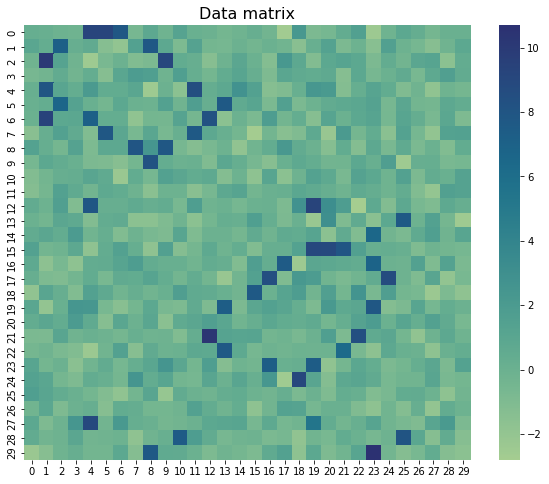

In [ ]:
f, ax = plt.subplots(figsize=(10,8))
plt.title("Data matrix",fontsize = 16)
ax = sns.heatmap(radar_sampled, cmap="crest")

# Section 2

### Noice threshold calculation

 $(900 \times 20)$ vector is given as the input to the "get_noise_threshold" function. It makes noise calculation algorithm simpler. 

In [ ]:
def get_noise_threshold(input_matrix, k, sigma_n):
  averaged_noise = []
  for i in range(0, 900):
    if i == 0:
      averaged_noise.append(np.mean(input_matrix[1, 5:11]))
    else:
      averaged_noise.append(np.mean(np.concatenate((input_matrix[i-1, 10:16], input_matrix[i, 5:11]), axis=0)))
  averaged_noise = np.array(averaged_noise)
  Threshold_V = averaged_noise + k * sigma_n
  return Threshold_V

threshold_voltage = (get_noise_threshold(sample_matrix, k, sigma_n).reshape(N,N))

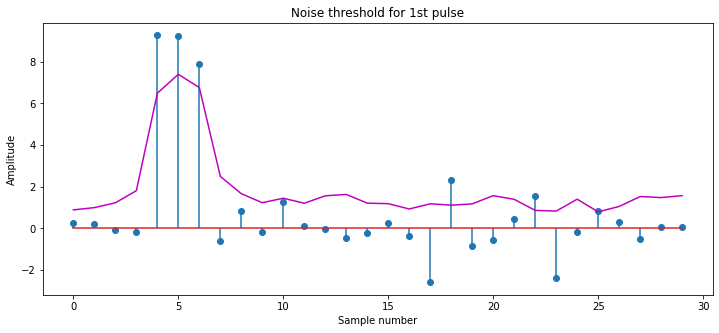

In [ ]:
plt.figure(figsize=(12, 5))
ax=plt.stem(radar_sampled[0,0:30],use_line_collection=True)
ax=plt.plot(threshold_voltage[0,0:30],color='m')
ax=plt.ylabel('Amplitude')
ax=plt.xlabel('Sample number')
ax=plt.title('Noise threshold for 1st pulse')
plt.show()

### Threshold Detector


$If\:\: V_{k}>V_{TH} \:\::$ 

>$ \:V_{k} =1 \:$ 

$else \:\::$

>$ \:V_{k} =0 \:$ 

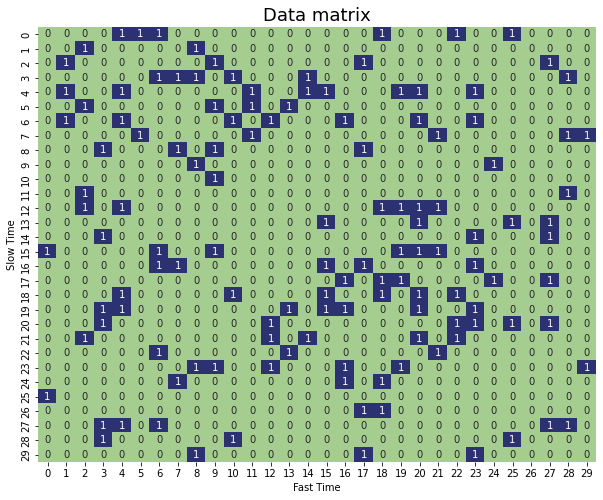

In [ ]:
data_matrix = 1 * (radar_sampled > threshold_voltage)

f, ax = plt.subplots(figsize = (10,8))
plt.title("Data matrix",fontsize = 18)
ax = sns.heatmap(data_matrix,annot=True,cbar=False,cmap="crest")
ax = ax.set(xlabel="Fast Time",ylabel="Slow Time")

### Target detection

If count in a perticular range slot is more than the half of echoes, there is a target in that range slot. In this case, a target is detected if count is larger than 15. Object is represented by 0.5. 



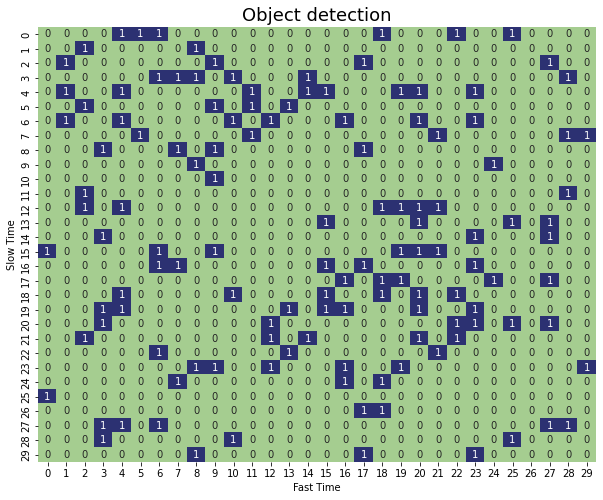

In [ ]:
def object_detection(data_matrix,threshold):
  data_matrix = data_matrix.astype(np.float32)
  echo_sum = np.sum(data_matrix,axis=0)
  object_bins = []
  for i, total in enumerate(echo_sum):
    if total >= threshold:
      object_bins.append(i)
      data_matrix[:,i] = 0.5 

  return data_matrix, object_bins

matrix_filtered, objects = object_detection(data_matrix,int(N/2))

f, ax = plt.subplots(figsize=(10,8))
plt.title('Object detection',fontsize = 18)
ax = sns.heatmap(matrix_filtered,annot=True,cbar=False,cmap="crest")
ax = ax.set(xlabel="Fast Time",ylabel="Slow Time")

### Selecting a threshold using Data Matrix

Threshold is seelcted by observing data matrix. 

New $V_{TH} \: = \: 6$ 

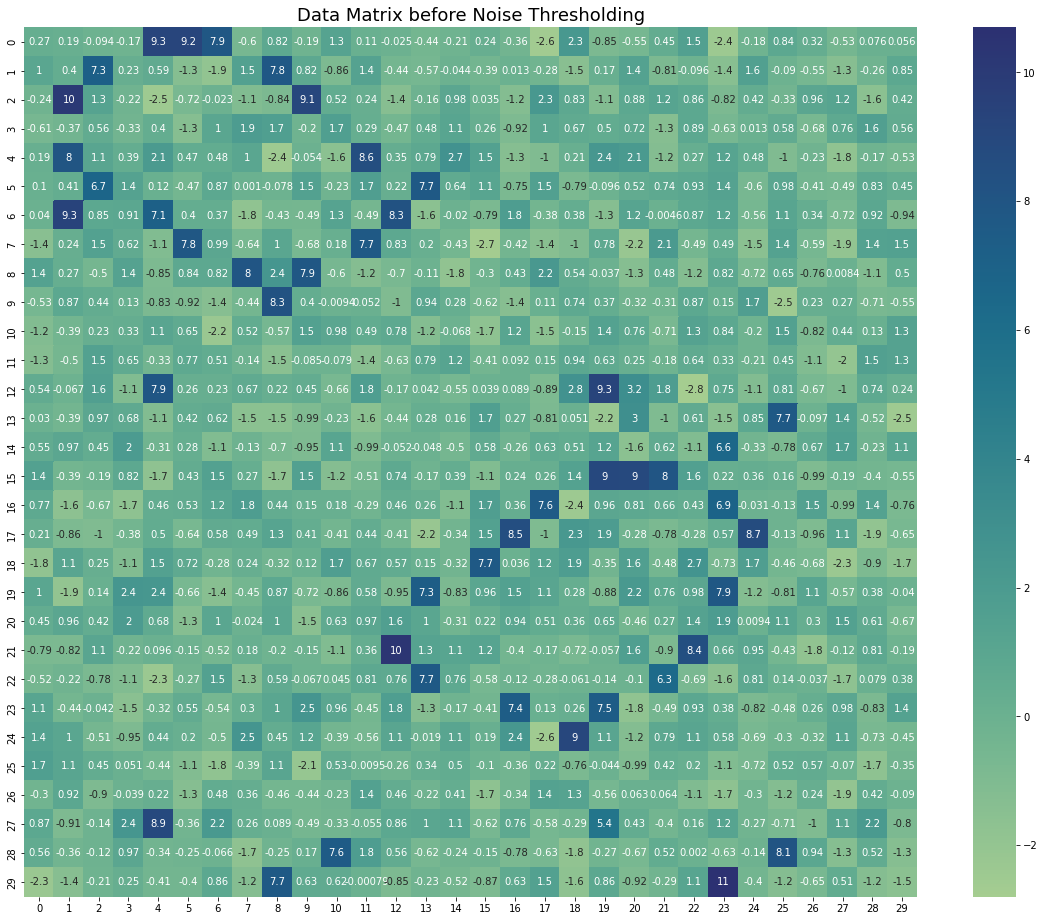

In [ ]:
f, ax = plt.subplots(figsize=(20,16))
plt.title("Data Matrix before Noise Thresholding",fontsize = 18)
ax = sns.heatmap(radar_sampled, annot=True, cmap="crest")

### Cloud detection

1.   Thresholding - Noise thresholding and selecting a manual threshold
2.   Filtering - 2D convolution
3.   Complete missing values
4.   Fill cloud contour - Flood fill

### Thresholding

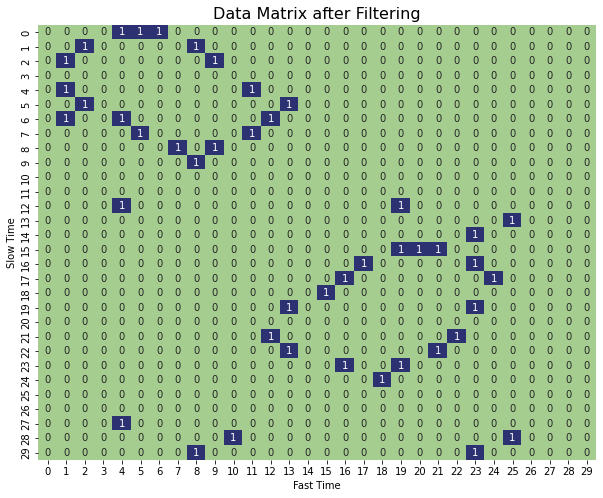

In [ ]:
# Apply noise thresholding
Radar_thresholded1 = np.where(radar_sampled>threshold_voltage,radar_sampled,0)

# Appply thresholding
Radar_thresholded2 = np.where(Radar_thresholded1>6,Radar_thresholded1,0)

# Convert to binary format
Radar_thresholded3 = np.where(Radar_thresholded2>0, 1, 0)

# Remove objects
Radar_thresholded3[:,objects] = 0

f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after Filtering',fontsize = 16)
ax = sns.heatmap(Radar_thresholded3,cbar=False,cmap="crest", annot=True)
ax = ax.set(xlabel="Fast Time",ylabel="Slow Time")

### Filtering

Source - https://github.com/detkov/Convolution-From-Scratch/blob/main/convolution.py

Convolution function used in this assignment was taken from this Github repository. 

In [ ]:
import numpy as np
from typing import List, Tuple, Union

def add_padding(matrix: np.ndarray, 
                padding: Tuple[int, int]) -> np.ndarray:
    n, m = matrix.shape
    r, c = padding
    
    padded_matrix = np.zeros((n + r * 2, m + c * 2))
    padded_matrix[r : n + r, c : m + c] = matrix
    
    return padded_matrix

def _check_params(matrix, kernel, stride, dilation, padding):
    params_are_correct = (isinstance(stride[0], int)   and isinstance(stride[1], int)   and
                          isinstance(dilation[0], int) and isinstance(dilation[1], int) and
                          isinstance(padding[0], int)  and isinstance(padding[1], int)  and
                          stride[0]   >= 1 and stride[1]   >= 1 and 
                          dilation[0] >= 1 and dilation[1] >= 1 and
                          padding[0]  >= 0 and padding[1]  >= 0)
    assert params_are_correct, 'Parameters should be integers equal or greater than default values.'
    if not isinstance(matrix, np.ndarray):
        matrix = np.array(matrix)
    n, m = matrix.shape
    matrix = matrix if list(padding) == [0, 0] else add_padding(matrix, padding)
    n_p, m_p = matrix.shape

    if not isinstance(kernel, np.ndarray):
        kernel = np.array(kernel)
    k = kernel.shape
    
    kernel_is_correct = k[0] % 2 == 1 and k[1] % 2 == 1
    assert kernel_is_correct, 'Kernel shape should be odd.'
    matrix_to_kernel_is_correct = n_p >= k[0] and m_p >= k[1]
    assert matrix_to_kernel_is_correct, 'Kernel can\'t be bigger than matrix in terms of shape.'
    
    h_out = np.floor((n + 2 * padding[0] - k[0] - (k[0] - 1) * (dilation[0] - 1)) / stride[0]).astype(int) + 1
    w_out = np.floor((m + 2 * padding[1] - k[1] - (k[1] - 1) * (dilation[1] - 1)) / stride[1]).astype(int) + 1
    out_dimensions_are_correct = h_out > 0 and w_out > 0
    assert out_dimensions_are_correct, 'Can\'t apply input parameters, one of resulting output dimension is non-positive.'

    return matrix, kernel, k, h_out, w_out

def conv2d(matrix: Union[List[List[float]], np.ndarray], 
             kernel: Union[List[List[float]], np.ndarray], 
             stride: Tuple[int, int] = (1, 1), 
             dilation: Tuple[int, int] = (1, 1), 
             padding: Tuple[int, int] = (0, 0)) -> np.ndarray:
    matrix, kernel, k, h_out, w_out = _check_params(matrix, kernel, stride, dilation, padding)
    matrix_out = np.zeros((h_out, w_out))
    
    b = k[0] // 2, k[1] // 2
    center_x_0 = b[0] * dilation[0]
    center_y_0 = b[1] * dilation[1]
    for i in range(h_out):
        center_x = center_x_0 + i * stride[0]
        indices_x = [center_x + l * dilation[0] for l in range(-b[0], b[0] + 1)]
        for j in range(w_out):
            center_y = center_y_0 + j * stride[1]
            indices_y = [center_y + l * dilation[1] for l in range(-b[1], b[1] + 1)]

            submatrix = matrix[indices_x, :][:, indices_y]

            matrix_out[i][j] = np.sum(np.multiply(submatrix, kernel))
    return matrix_out

In [ ]:
# Only odd kernels can be used with this function

kernel7 = np.array([[1, 1, 1, 1, 1, 1, 1], 
                   [1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1]])

kernel3 = np.array([[1, 1, 1], 
                   [1, 1, 1],
                   [1, 1, 1]])

kernel5 = np.array([[1, 1, 1, 1, 1], 
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1]])

2D convolution was done using a 7 x 7 kenel with 3 x 3 padding. Threshold was selected as 3 by observing Radar_filtered1. Lot of isolated value situated far away form clouds were removed using this. But, isolated values close to cloud can not be removed using this kernel. 

In [ ]:
Radar_filtered1 = conv2d(matrix=Radar_thresholded3, kernel=kernel7, stride=(1, 1), padding=(3, 3), dilation=(1,1))
Radar_filtered2 = np.where(Radar_filtered1>3,Radar_thresholded3,0)

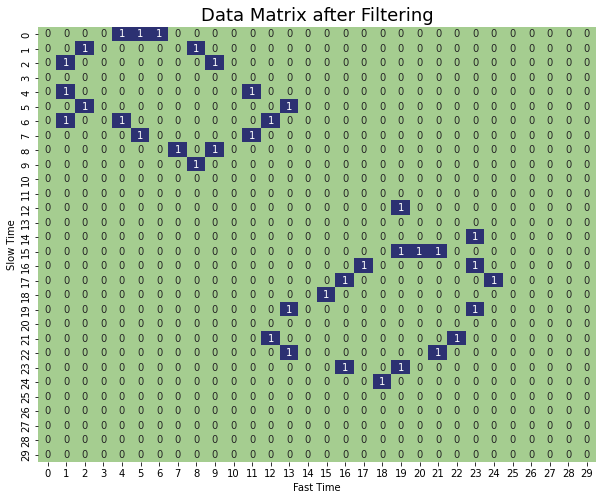

In [ ]:
f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after Filtering',fontsize = 18)
ax = sns.heatmap(Radar_filtered2, cmap="crest", annot=True,cbar=False)
ax = ax.set(xlabel="Fast Time",ylabel="Slow Time")

### Fill gaps

Fill one gap

Case 1 and Case 2

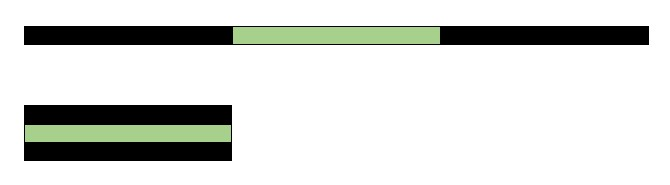

In [ ]:
# Missing ones in raws
count =0 
for line in Radar_filtered2:
  line = line.tolist()
  for i in range(len(line)-2):
    if (line[i]==1 and line[i+2]==1 and line[i+1]==0):
      Radar_filtered2[count,:][i+1] = 1
  count+=1

# Missing ones in columns
for j in range(30):
  line = Radar_filtered2[:,j]
  for i in range(len(line)-2):
    if line[i]==1 and line[i+2]==1 and line[i+1]==0:
      Radar_filtered2[:,j][i+1] = 1

Case 3 - 8

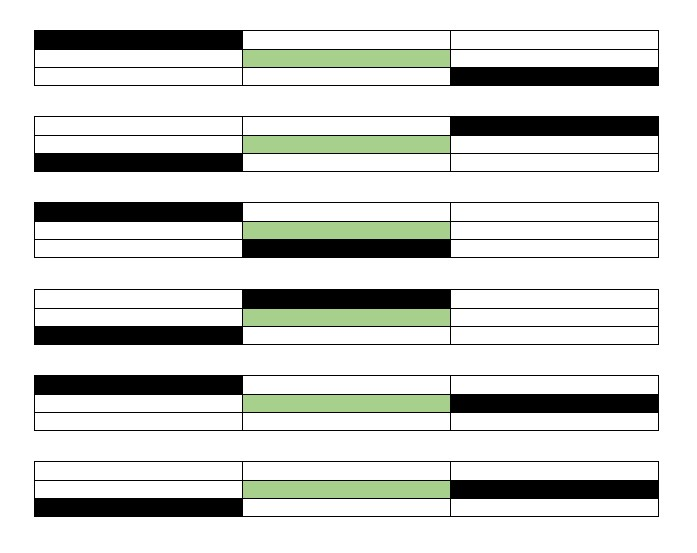

In [ ]:
# Diagonal with gradient = -1

for j in range(28):
  for i in range(28):
    if Radar_filtered2[j,i]==1 and Radar_filtered2[j+2,i+2]==1 and Radar_filtered2[j+1,i+1]==0:
      Radar_filtered2[j+1,i+1] = 1

# Diagonal with gradient = 1

for j in range(2,30):
  for i in range(2,30):
    if Radar_filtered2[j,i]==1 and Radar_filtered2[j-2,i+2]==1 and Radar_filtered2[j-1,i+1]==0:
      Radar_filtered2[j-1,i+1] = 1

# Diagonal2 gradient = -1

for j in range(28):
  for i in range(28):
    if Radar_filtered2[j,i]==1 and Radar_filtered2[j+2,i+1]==1 and Radar_filtered2[j+1,i+1]==0:
      Radar_filtered2[j+1,i+1] = 1

# Diagonal2 gradient = 1

for j in range(2,30):
  for i in range(0,29):
    if Radar_filtered2[j,i]==1 and Radar_filtered2[j-2,i+1]==1 and Radar_filtered2[j-1,i+1]==0:
      Radar_filtered2[j-1,i+1] = 1

# Diagonal3 gradient = -1

for j in range(29):
  for i in range(28):
    if Radar_filtered2[j,i]==1 and Radar_filtered2[j+1,i+2]==1 and Radar_filtered2[j+1,i+1]==0:
      Radar_filtered2[j+1,i+1] = 1

# Diagonal3 gradient = 1

for j in range(1,30):
  for i in range(0,28):
    if Radar_filtered2[j,i]==1 and Radar_filtered2[j-1,i+2]==1 and Radar_filtered2[j-1,i+1]==0:
      Radar_filtered2[j-1,i+1] = 1

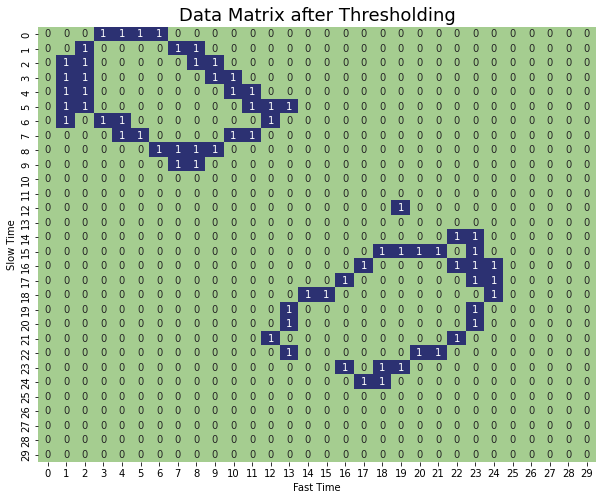

In [ ]:
f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after Thresholding',fontsize = 18)
ax = sns.heatmap(Radar_filtered2, cmap="crest", annot=True,cbar=False)
ax = ax.set(xlabel="Fast Time",ylabel="Slow Time")

2D convolution was done using a 3 x 3 kenel with 1 x 1 padding. Threshold was selected as 1 by observing Radar_filtered1.

Here, a small kernel is used to detect noise near clouds. Kernel is used after filling "one gaps". Therefore removal of correct values can be minimized. 

In [ ]:
Radar_filtered1 = conv2d(matrix=Radar_filtered2, kernel=kernel3, stride=(1, 1), padding=(1, 1), dilation=(1,1))
Radar_filtered2 = np.where(Radar_filtered1>1,Radar_filtered2,0)

Fill two gaps

Case 9 and case 10

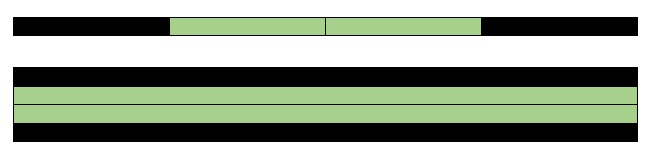

In [ ]:
# Missing ones in raws
count = 0
for line in Radar_filtered2:
  line = line.tolist()
  for i in range(len(line)-3):
    if (line[i]==1 and line[i+3]==1 and line[i+1]==0 and line[i+2]==0):
      Radar_filtered2[count,:][i+1], Radar_filtered2[count,:][i+2] = 1, 1
  count+=1

# Missing ones in Columns
for j in range(30):
  line = Radar_filtered2[:,j]
  for i in range(len(line)-3):
    if (line[i]==1 and line[i+3]==1 and line[i+1]==0 and line[i+2]==0):
      Radar_filtered2[:,j][i+1], Radar_filtered2[:,j][i+2] = 1, 1

Case 11 to 14

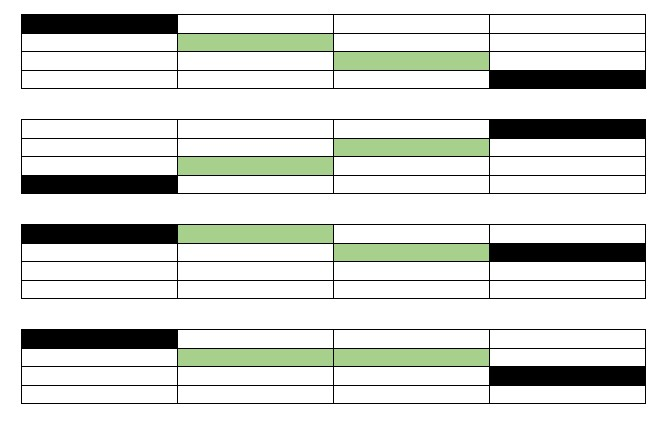

In [ ]:
# Diagonal with gradient = -1

for j in range(27):
  for i in range(27):
    if Radar_filtered2[j,i]==1 and Radar_filtered2[j+3,i+3]==1 and Radar_filtered2[j+1,i+1]==0 and Radar_filtered2[j+2,i+2]==0:
      Radar_filtered2[j+1,i+1], Radar_filtered2[j+2,i+2] = 1, 1

# Diagonal with gradient = 1

for j in range(3,30):
  for i in range(3,30):
    if Radar_filtered2[j,i]==1 and Radar_filtered2[j-3,i+3]==1 and Radar_filtered2[j-1,i+1]==0 and Radar_filtered2[j-2,i+2]==0:
      Radar_filtered2[j-1,i+1], Radar_filtered2[j-2,i+2] = 1, 1


# Diagonal3 gradient = -1

for j in range(29):
  for i in range(27):
    if Radar_filtered2[j,i]==1 and Radar_filtered2[j+1,i+3]==1 and Radar_filtered2[j,i+1]==0 and Radar_filtered2[j+1,i+2]==0:
      Radar_filtered2[j,i+1], Radar_filtered2[j+1,i+2] = 1, 1

# Diagonal3 gradient = -1

for j in range(28):
  for i in range(27):
    if Radar_filtered2[j,i]==1 and Radar_filtered2[j+2,i+3]==1 and Radar_filtered2[j+1,i+1]==0 and Radar_filtered2[j+1,i+2]==0:
      Radar_filtered2[j+1,i+1], Radar_filtered2[j+1,i+2] = 1, 1

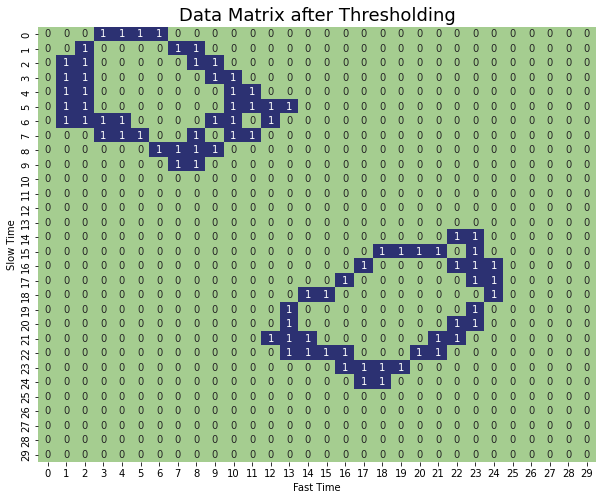

In [ ]:
f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after Thresholding',fontsize = 18)
ax = sns.heatmap(Radar_filtered2, cmap="crest", annot=True, cbar=False)
ax = ax.set(xlabel="Fast Time",ylabel="Slow Time")

### Fill cloud contour

Flood fill function in OpenCV was used to fill the cloud. 

In [ ]:
Radar_filtered2 = Radar_filtered2.astype(np.uint8)
flood_fill = cv.floodFill(Radar_filtered2, None, seedPoint=(0,0), newVal=5)

flood_fill=flood_fill[1].reshape(no_echos,N)
data_matrix_final = np.where(flood_fill==5,0,1)

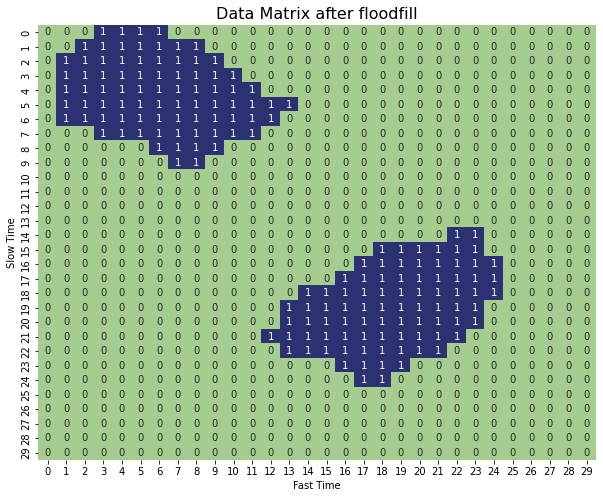

In [ ]:
f, ax = plt.subplots(figsize=(10,8))
plt.title('Data Matrix after floodfill',fontsize = 16)
ax = sns.heatmap(data_matrix_final,annot=True,cbar=False,cmap="crest")
ax = ax.set(xlabel="Fast Time",ylabel="Slow Time")

# Section 3

### Visualizing cloud and objects

>$Cloud = 1$

>$Object = 0.5$

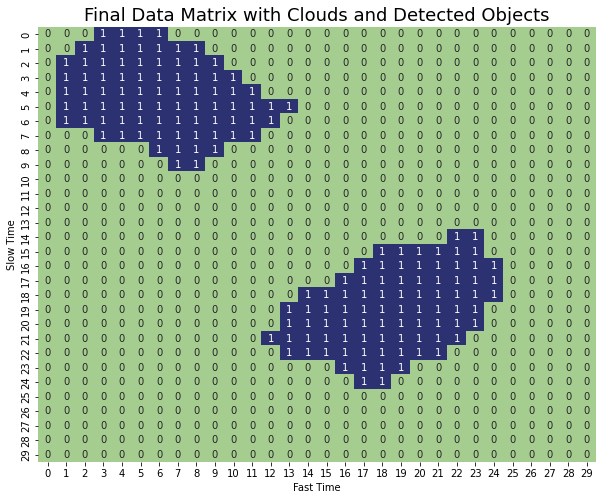

In [ ]:
# Add objects
data_matrix_final = data_matrix_final.astype(np.float32)
data_matrix_final[:,objects]=0.5

f, ax = plt.subplots(figsize=(10,8))
plt.title('Final Data Matrix with Clouds and Detected Objects', fontsize = 18)
ax = sns.heatmap(data_matrix_final, annot=True, cbar=False, cmap="crest")
ax = ax.set(xlabel="Fast Time",ylabel="Slow Time")

# Section 4

### Range

>$T_s = \frac{1}{F_s} = 18.52\mu s $

>$\Delta R = \frac{c \times T_{s}}{2} = 2778m $ 

Therefore size of one range bin is 2778.

In [ ]:
object_range = [(x+1)*2778 for x in objects]

### Azimuth angle

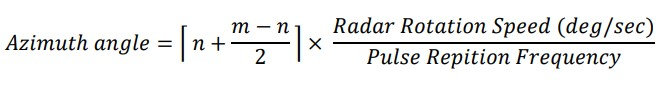

* Calculate m and n

In [ ]:
# Finding n
az_n = []
for obj in objects:
  for i in range(0,30):
    if data_matrix[i][obj] == 1:
      az_n.append(i + 1)
      break

# Finding m
az_m = []
for obj in objects:
  for i in range(29,-1,-1):
    if data_matrix[i][obj] == 1:   
      az_m.append(i + 1)
      break

In [ ]:
azimuth_angle = []

for m, n in zip(az_m,az_n):
  azimuth_angle.append((n + (m-n)/2)*(revol_speed*6/fr))

In [ ]:
for rng, azimuth in zip(object_range, azimuth_angle):
  print(f"Range - {rng}m, Azimuth - {azimuth}")